In [1]:
import numpy as np
import pandas as pd
import os
from os.path import join
import pickle
import sys
from keras.models import load_model
from keras.utils import to_categorical
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn import svm
import seaborn as sn

Using TensorFlow backend.


In [2]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from pprint import pprint
from time import time

In [3]:
thisPath = os.getcwd()
os.chdir("../../code")
projectDir = os.getcwd()
from evalUtils import plotModelHist, UrgentVRoutne, reportBinaryScores

In [4]:
yTestPath = r"D:\Projects\OCT-Image-Classification\PreprocessedData\preprocessedForCNN\224x224\targetData_(224, 224, 3)_test.npy"
yTrueTest = np.load(yTestPath)

yTrnPath = r"D:\Projects\OCT-Image-Classification\PreprocessedData\preprocessedForCNN\224x224\targetData_(224, 224, 3)_train.npy"
yTrueTrn = np.load(yTrnPath)

yValPath = r"D:\Projects\OCT-Image-Classification\PreprocessedData\preprocessedForCNN\224x224\targetData_(224, 224, 3)_val.npy"
yTrueVal = np.load(yValPath)

yTrueDict = {"trn": yTrueTrn, 
             "test": yTrueTest, 
             "val": yTrueVal}

In [5]:
classMap = {
    "NORMAL": 0,
    "DRUSEN": 1,
    "CNV": 2,
    "DME": 3}

classMapR = {i:lbl for lbl, i in classMap.items()}

In [6]:
modelsPath = r"D:\Projects\OCT-Image-Classification\modelOutput\featureExtraction"
modelName = "ResNet50"
featuresDict = {}
datasets = ["trn", "test", "val"]

print(modelName)
modelDir = join(modelsPath, modelName)
for dset in datasets:
    print('\t', dset)
    fName = "{}_features_{}.npy".format(modelName, dset)
    featuresArray = np.load(join(modelDir, fName))
    featuresDict[dset] = featuresArray

ResNet50
	 trn
	 test
	 val


pca fitting


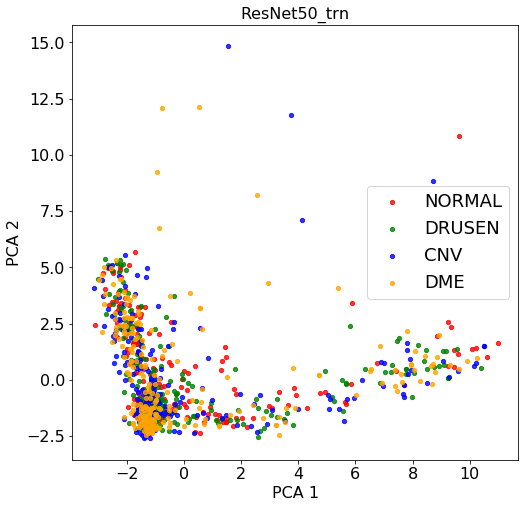

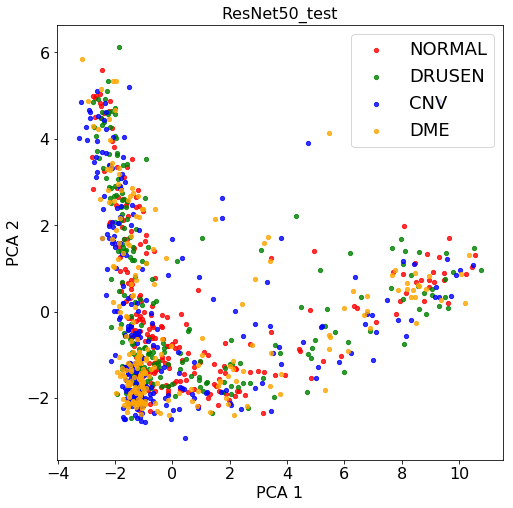

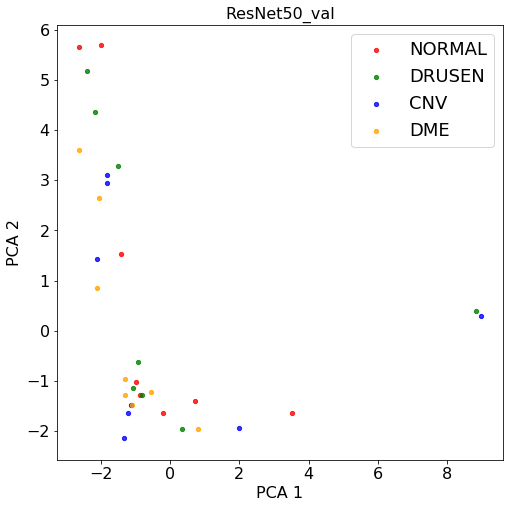

In [7]:
#Vizualize
fs = 16
tickSize=16
colours = ['r', 'g', 'b', 'orange']
datasets = ["trn", "test", "val"]

n_components = 2
for i, dset in enumerate(datasets):
    yTrue = yTrueDict[dset]
    features = featuresDict[dset]
    features_mean = features.max(axis=(1, 2))
    if dset == 'trn': 
        print('pca fitting')
        pca = PCA(n_components=n_components).fit(features_mean)
    features_pca = pca.transform(features_mean)
    fig=plt.figure(figsize=(8, 8))
    for lbl in np.unique(yTrue):
        idx = np.where(yTrue==lbl) 
        pca1 = features_pca[idx, 0]
        pca2 = features_pca[idx, 1]
        plt.scatter(pca1, pca2, color=colours[lbl], 
                s=18, alpha = 0.8, label=classMapR[lbl])
    plt.title(modelName + '_' + dset, fontsize=fs)
    plt.xlabel('PCA 1', fontsize=fs)
    plt.ylabel('PCA 2', fontsize=fs)
    plt.tick_params(axis='both', labelsize=tickSize)
    plt.legend(prop={'size': 18})
    plt.show()
del pca


(1000, 2048)


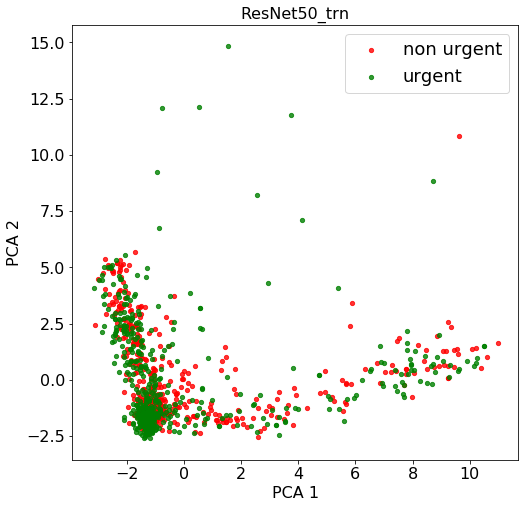

(968, 2048)


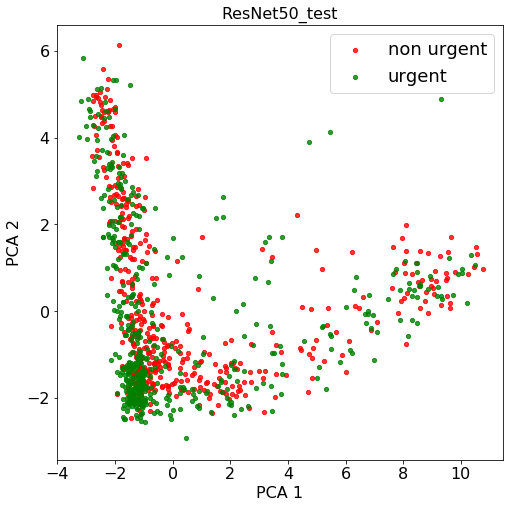

(32, 2048)


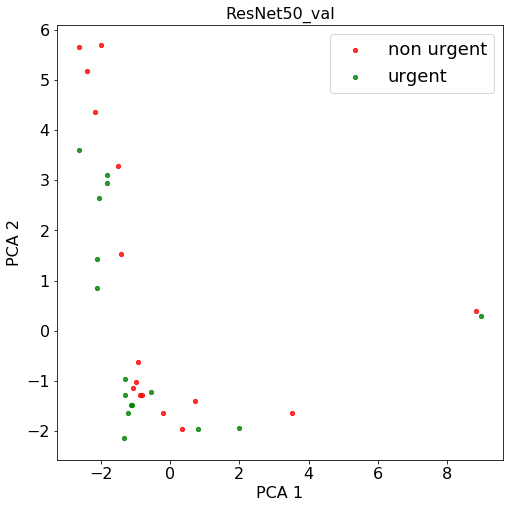

In [8]:
urgentLbls = ['non urgent', 'urgent']
for i, dset in enumerate(datasets):
    yTrue = yTrueDict[dset]
    yTrue1Hot = to_categorical(yTrue)
    yTrue = UrgentVRoutne(yTrue1Hot, classMap).astype(np.int)

    features = featuresDict[dset]
    features_mean = features.max(axis=(1, 2))
    print(features_mean.shape)
    if dset == 'trn':
        pca = PCA(n_components=n_components).fit(features_mean)
    features_pca = pca.transform(features_mean)
    fig=plt.figure(figsize=(8, 8))
    for lbl in np.unique(yTrue):
        idx = np.where(yTrue==lbl) 
        pca1 = features_pca[idx, 0]
        pca2 = features_pca[idx, 1]
        plt.scatter(pca1, pca2, color=colours[lbl], 
                s=18, alpha = 0.8, label=urgentLbls[lbl])
    plt.title(modelName + '_' + dset, fontsize=fs)
    plt.xlabel('PCA 1', fontsize=fs)
    plt.ylabel('PCA 2', fontsize=fs)
    plt.tick_params(axis='both', labelsize=tickSize)
    plt.legend(prop={'size': 18})
    plt.show()
del pca

In [9]:
def fineTunePipeline(xTrn, yTrn):
    estimators = [('reduce_dim', PCA()), ('clf', svm.SVC())]
    pipeline = Pipeline(estimators)
    params = dict(reduce_dim__n_components=[50, 200, 500],
                  clf__C=[1, 5, 10, 15],
                  clf__gamma=[0.00001, 0.0001, 0.0005, 0.01, 0.1, 1.0],
                  clf__degree=[2, 3, 4],
                  clf__kernel=['linear', 'rbf', 'poly'])
    grid_search = GridSearchCV(pipeline, param_grid=params,  
                           cv=5, n_jobs=-1, verbose=1)

    t0 = time()
    grid_search.fit(xTrn, yTrn)
    print("done in %0.3fs" % (time() - t0))
    print()

    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(params.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))
    return best_parameters

In [ ]:
def flattenFeatures(x):
    x_flat = []
    for xi in x:
        xi_flat = xi.flatten()
        x_flat.append(xi_flat)
    x_flat = np.array(x_flat)
    return x_flat

In [ ]:
featuresTrn = featuresDict['trn']
featuresTrn = featuresTrn.mean(axis=(1, 2))
best_parameters = fineTunePipeline(featuresTrn, yTrueTrn)


Fitting 5 folds for each of 648 candidates, totalling 3240 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   55.5s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  8.4min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed: 15.1min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed: 24.3min


In [ ]:
# Fit SVM
C = 15
Ker = 'linear'
nComponents = 400

featuresTrn = featuresDict['trn']
featuresTrn = featuresTrn.mean(axis=(1, 2))
pca = PCA(n_components=nComponents, ).fit(featuresTrn, )
featuresPCA = pca.transform(featuresTrn)

clf = svm.SVC(C=C, kernel=Ker, probability=True)
clf.fit(featuresPCA, yTrueTrn)

In [ ]:
for i, dset in enumerate(datasets):
    print(dset)
    yTrue = yTrueDict[dset]
    yTrue1Hot = to_categorical(yTrue)
    yTrueBin = UrgentVRoutne(yTrue1Hot, classMap).astype(np.int)
    features = featuresDict[dset]
    features_mean = features.mean(axis=(1, 2))
    features_pca = pca.transform(features_mean)
    yPred = clf.predict_proba(features_pca)
    classAcc = accuracy_score(yTrue,
                              yPred.argmax(axis=1))
    yPredUrgent = UrgentVRoutne(yPred, classMap)
    print('\t 4 class accuracy: {0:.3g}'.format(classAcc))
    scores = reportBinaryScores(yTrueBin, yPredUrgent, v=1)
    acc, tpr, tnr, plr, nlr = scores
    fprs, tprs, _ = roc_curve(yTrueBin, yPredUrgent,)
    aucUrgent = auc(fprs, tprs)
    print('\t auc {}'.format(aucUrgent))